In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:38425 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [3]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

14.629741907119751


# Define functions in package:

# Clustering for DWT

In [4]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [5]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

In [6]:
#Function to compute single level for feature data
def single_level_class(data_set, level, wavelet_time = 'haar', wavelet_space='haar', metric='euclidean', n_neighbors=3, eps_percentile=98, ratio_dwt=0.001):
    '''The following code computes one level of WaveScan'''
    
    startt=time.time()
    
    lvl = str(level)
    print("LEVEL: " + lvl)
    
    #Compute DWT
    #start = time.time()
    #wp = pywt.wavedecn(data=data_set[feature].data, wavelet=wave, level = min(level,max_level), mode='constant')
    #end = time.time()
    #diff = str(end-start)
    #print("DWT:" + diff)
    
    #Compute DWT in space - the data for LOCA has space as [1,2].  Note that we don't need any DWT coef. other than approximation at each level.
    start = time.time()
    wp = pywt.wavedecn(data=data_set, wavelet = wavelet_space, level = min(level,max_level), axes = [1,2])
    wp = pywt.wavedecn(data=wp[0], wavelet = wavelet_time, level = min(level,max_level), axes = [0])
    
    
    #Reshape the data for DBScan
    start = time.time()
    shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
    shaped = np.transpose(shaped)
    shaped.shape
    
    #Filter out the nan values for clustering
    data, index, index_nan = filter_out_nan(shaped)
    
    end = time.time()
    diff = str(end-start)
    print("Prep Data:" + diff)
    #Discover the epsilon for DBScan using knn. 
    start = time.time()
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    #Set the distance to use as within eps_percentile:
    epsilon = np.percentile(distances[:,[1,-1]], eps_percentile)
    print(epsilon)
    
    #Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
    # at least 2).
    min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
    end = time.time()
    diff = str(end-start)
    print("Find Params:" + diff)
    
    #Perform db scan and return the result
    start = time.time()
    classes = DBSCAN(eps=epsilon, min_samples=min_size, metric=metric).fit_predict(data)
    end = time.time()
    diff = str(end-start)
    print("DBSCAN:" + diff)
    
    #Filter back in the nan values before reshaping:
    start = time.time()
    classes = filter_in_nan(classes, index, index_nan)
    
    #Reshape classes to match back up with original
    classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))
    
    end = time.time()
    diff = str(end-start)
    print("Find Classes:" + diff)
    
    
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    print("")
    
    return classes

# Index maps to return labels to initial data

In [7]:
#First, dwt_length is run to compute the length of each wavelet transform level.  This information is used to build the functions that will map the index up one level in the DWT (map_back_index)

In [8]:
#Record the lengths of the data at each wavelet transform.  This function is run outside map_back_classes
def dwt_length(data, wavelet):
    
    dwt_lengths = [data.size]
    max_level = pywt.dwt_max_level(data_len = data.size, filter_len = pywt.Wavelet(wavelet).dec_len)
    
    for i in range(max_level):
        l = pywt.dwt_coeff_len(dwt_lengths[i], pywt.Wavelet(wavelet).dec_len, mode='symmetric')
        dwt_lengths.append(l)
    
    return dwt_lengths

In [9]:
def middle_match(data_len,wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build the first row of the matrix
    I_m = np.zeros(data_len)
    I_m[:w_len] = w_fil
    
    #Make the shift matrix
    row_number = int(np.ceil((data_len-w_len)/2))
    if data_len%2 == 0:
        for j in range(1, row_number+1):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number+1,data_len))
    else:
        for j in range(1, row_number):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number,data_len))        
        
        
    return I_m

In [10]:
def top_match(data_len, wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build blank matrix
    row_number = int(np.ceil((w_len)/2))
    I_t = np.zeros((row_number-1,data_len))
    
    #Make the shift matrix
    for j in range(1,row_number):
        overflow = w_fil[:2*j]
        overflow = np.flip(overflow, axis=0)
        row_o = np.zeros(data_len)
        row_o[:2*j] = overflow
        
        leftover = w_fil[2*j:]
        row_l = np.zeros(data_len)
        row_l[:leftover.size] = leftover
        
        row = row_o + row_l      
        
        I_t[j-1] = row
    
    return I_t

In [11]:
def bot_match(data_len, wavelet):
   
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len

    row_number = int(np.ceil((w_len)/2))
    if data_len%2 ==0:
        I_b = np.zeros((row_number-1,data_len))
        for j in range(1,row_number):
            overflow = w_fil[-2*j:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j:] = overflow
            
            
            leftover = w_fil[:-2*j]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover
            
            row = row_o + row_l
            
            I_b[j-1] = row         
    else:
        I_b = np.zeros((row_number,data_len))
        for j in range(1,row_number+1):         
            overflow = w_fil[-2*j+1:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j+1:] = overflow
            
            leftover = w_fil[:-2*j+1]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover

            
            row = row_o + row_l
            
            I_b[j-1] = row
            
    return I_b

In [12]:
#Function used to build filter matrix for mapping classes back one level
def filter_matrix(data_len, wavelet):
    
    I_m = middle_match(data_len, wavelet)
    I_t = top_match(data_len, wavelet)
    I_b = bot_match(data_len, wavelet)
    
    I = np.concatenate((I_t,I_m), axis=0)
    I = np.concatenate((I,I_b), axis=0)
    
    return I

In [13]:
#Function used to discover classes at one stage higher resolution
def map_back_index(wavelet, dwt_lengths, max_level):
    
    index_up=[]
    
    for j in range(max_level):
        I = filter_matrix(dwt_lengths[j], wavelet)
        I = np.abs(I)
        classes_index = np.argmax(I,axis=0)
        index_up.append(classes_index)
        
    return index_up

# Having clustered, we now map each class back to initial data

In [14]:
def map_back_classes(data_classes, index_up_lat, index_up_lon, max_level):
    
    final_class = []
    for j in range(max_level):
        classt = data_classes[j]
        for i in range(j+1):
            classt = classt[index_up_lat[j-i]][:,index_up_lon[j-i]]
        final_class.append(classt)
        
    return final_class

# Test Algorithm on Data:

# Prepare data for processing

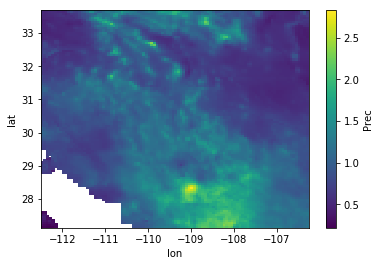

In [15]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(200, 305), lon=slice(200, 300), time=slice(0, 240))
ds2.Prec.mean('time').plot()

In [16]:
#Create a small amount of noise to perturb the data by.  The idea is to make values of zero close (but not equal to) zero.
noise = da.random.normal(0, scale = 1/(1000000), size = (ds2.time.size, ds2.lat.size, ds2.lon.size), chunks = (1,ds2.lat.size, ds2.lon.size) )

In [17]:
data = ds2+noise

In [18]:
#Prec data
mean = np.array(ds2.Prec.mean())
data_Prec = da.nan_to_num(data.Prec.data)
data_Prec
data_Prec[data_Prec==0] = mean

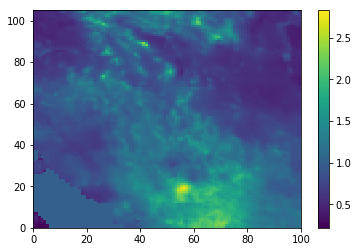

In [19]:
#plot
data_p = data_Prec.mean(axis=0)
p = plt.pcolormesh(data_p)
plt.colorbar(p)

In [24]:
#Tmax data
mean = np.array(ds2.Tmax.mean())
data_Tmax = da.nan_to_num(data.Tmax.data)
data_Tmax
data_Tmax[data_Tmax==0] = mean

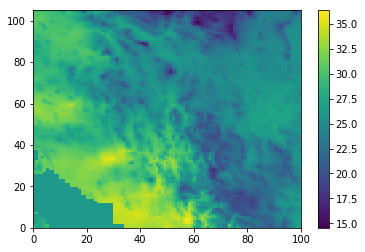

In [25]:
#plot
data_p = data_Tmax.mean(axis=0)
p = plt.pcolormesh(data_p)
plt.colorbar(p)

In [26]:
#Tmin data
mean = np.array(ds2.Tmin.mean())
data_Tmin = da.nan_to_num(data.Tmin.data)
data_Tmin
data_Tmin[data_Tmin==0] = mean

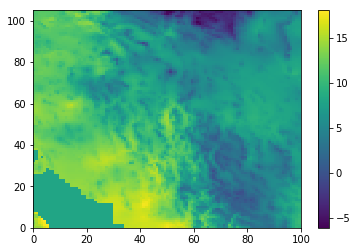

In [27]:
#plot
data_p = data_Tmin.mean(axis=0)
p = plt.pcolormesh(data_p)
plt.colorbar(p)

# Set up Wavelet Transform

In [139]:
#pywt.wavelist()
#Information : http://wavelets.pybytes.com/
#print(pywt.Wavelet('haar'))

In [29]:
#Set the number of levels for DWT, as well as the wavelet

#First, the time information:
wave_time = 'db2'
max_level_time = pywt.dwt_max_level(data_len = ds2.time.size, filter_len = pywt.Wavelet(wave_time).dec_len) 

#Next, space information:
wave_space = 'haar'
max_level_lat= pywt.dwt_max_level(data_len = ds2.lat.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
max_level_lon= pywt.dwt_max_level(data_len = ds2.lon.size, filter_len = pywt.Wavelet(wave_space).dec_len) 


max_level= min(max_level_lat, max_level_lon, max_level_time)

In [30]:
#In order to invert the DWT classifier, need lengths for lat, lon, time:

#dwt_lengths_time = dwt_length(ds2.time, wave_time)
dwt_lengths_lat = dwt_length(ds2.lat, wave_space)
dwt_lengths_lon = dwt_length(ds2.lon, wave_space)

#index_up_time = map_back_index(wave_time,dwt_lengths_time,max_level_time)
index_up_lat = map_back_index(wave_space,dwt_lengths_lat,max_level_lat)
index_up_lon = map_back_index(wave_space,dwt_lengths_lon,max_level_lon)

In [65]:
#Build a nan-mask to be used on data sets once classified:
nan_mask = np.isnan(ds2.Prec.data[0])
nan_mask = np.array(nan_mask)
nan_mask = nan_mask*np.array(ds2.Prec.data[0])

# Test on climate data

In [67]:
#Gather all the Prec classes for each level:
%reset_selective -f Prec_classes

Prec_classes = []
for i in range(max_level+1):
    classes = single_level_class(data_Prec, wavelet_time = 'db2', level = i)
    Prec_classes.append(classes)

LEVEL: 0
Prep Data:1.7458488941192627
4.226356942542731
Find Params:74.23279356956482
DBSCAN:46.33635640144348
Find Classes:0.0014569759368896484
TOTAL: 124.39400959014893

LEVEL: 1
Prep Data:0.41312193870544434
9.807706409434134
Find Params:13.567297220230103
DBSCAN:7.442367792129517
Find Classes:0.0005643367767333984
TOTAL: 24.68496298789978

LEVEL: 2
Prep Data:0.10761356353759766
21.810833920822446
Find Params:3.312356948852539


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


DBSCAN:1.7682654857635498
Find Classes:0.0002567768096923828
TOTAL: 7.110781669616699

LEVEL: 3
Prep Data:0.02809286117553711


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


46.85673443519104
Find Params:1.1713690757751465
DBSCAN:0.4269697666168213
Find Classes:0.00033473968505859375
TOTAL: 3.3381447792053223

LEVEL: 4
Prep Data:0.007594108581542969
96.05829262102127
Find Params:0.2703704833984375
DBSCAN:0.161482572555542
Find Classes:0.00011587142944335938
TOTAL: 2.0621089935302734

LEVEL: 5


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Prep Data:0.002613067626953125
152.24971363160446
Find Params:0.14309167861938477
DBSCAN:0.08074808120727539
Find Classes:0.00032639503479003906
TOTAL: 2.1210289001464844

LEVEL: 6
Prep Data:0.0008418560028076172
481.0650743836757
Find Params:0.08031153678894043
DBSCAN:0.03308534622192383
Find Classes:6.985664367675781e-05
TOTAL: 1.6874628067016602



In [70]:
Prec_classes_f = map_back_classes(Prec_classes, index_up_lat, index_up_lon, max_level)
for i in range(max_level):
    Prec_classes_f[i] = Prec_classes_f[i]*nan_mask

0
1
2
3
4
5


Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/ddesantis/miniconda3/lib/python3.6/site-packages/tornado/gen

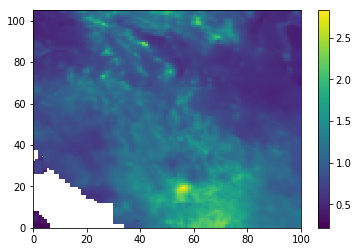

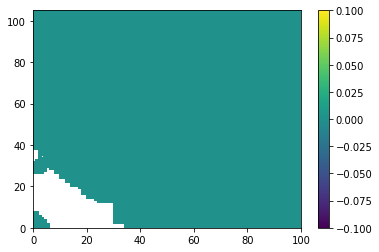

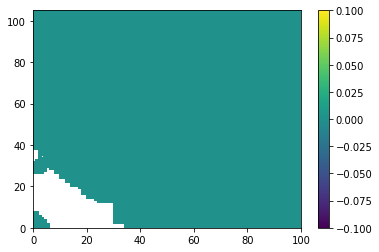

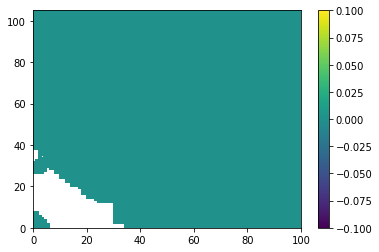

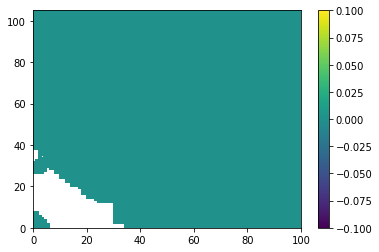

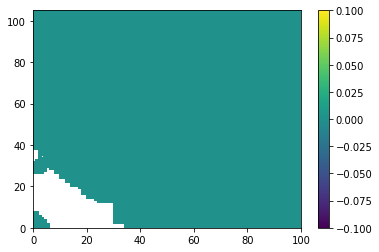

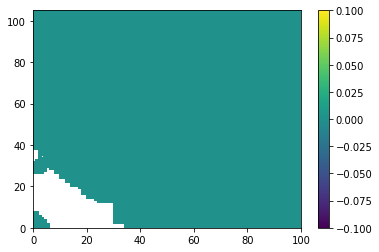

In [71]:
#Plot the different levels of classification verses the historical average:
plt.figure(-1)
p = plt.pcolormesh(ds2.Prec.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Prec_classes_f[i])
    plt.colorbar(p)

In [34]:
test = Prec_classes[0]